This script adds a "type" column to the saccades and fixations files which marks them as valid or invalid depending on wheather they fall within the time of blinks. 

Then it created a Histogram plot to illustrate the temporal relationship beetween blinks and saccades/fixations.


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
base_path = ""

stats = [] # to keep track of the number of valid and invalid saccades and fixations for each session

# loading files
for folder in os.listdir(base_path):
    participant_path = os.path.join(base_path, folder)
    participant_id = folder[-4:]
    if not os.path.isdir(participant_path):
        continue
    blinks_path = os.path.join(participant_path, 'blinks.csv')
    saccades_path = os.path.join(participant_path, 'saccades.csv')
    fixations_path = os.path.join(participant_path, 'fixations.csv')
  
    try:
        df_blinks = pd.read_csv(blinks_path)
        df_saccades = pd.read_csv(saccades_path)
        df_fixations = pd.read_csv(fixations_path)
    except Exception as e:
        print('Failed to read', blinks_path, e)
        print('Failed to read', saccades_path, e)
        print('Failed to read', fixations_path, e)  
        continue

    # Sort by timestamp (should be sorted already, but in case for proper merging)
    df_blinks = df_blinks.sort_values("start timestamp [ns]")
    df_saccades = df_saccades.sort_values("start timestamp [ns]")
    df_fixations = df_fixations.sort_values("start timestamp [ns]")

    ## function for filtering events within blinks (adding type valid or not valid to the events)
    def add_type(df_events, df_blinks):

        # add type column to events, default to 'valid'
        df_events['type'] = 'valid'

        # change type of events that fall within blinks to 'invalid'
        for _, blink in df_blinks.iterrows():
            start, end = blink['start timestamp [ns]'], blink['end timestamp [ns]']
            mask = (df_events['start timestamp [ns]'] >= start) & (df_events['start timestamp [ns]'] <= end)
            df_events.loc[mask, 'type'] = 'invalid'
        return df_events

    # clean df_saccades and df_fixations
    df_saccades_new = add_type(df_saccades, df_blinks)
    df_fixations_new = add_type(df_fixations, df_blinks)

    # make a file with the number of valid and invalid saccades and fixations for each session
    stats.append({
        'participant_id': participant_id,
        'valid_saccades': df_saccades_new[df_saccades_new['type'] == 'valid'].shape[0],
        'invalid_saccades': df_saccades_new[df_saccades_new['type'] == 'invalid'].shape[0],
        'valid_fixations': df_fixations_new[df_fixations_new['type'] == 'valid'].shape[0],
        'invalid_fixations': df_fixations_new[df_fixations_new['type'] == 'invalid'].shape[0]
    })

    # save to a new folder
    new_path = os.path.join(base_path, 'new_fixations_saccades')
    if not os.path.exists(new_path):
        os.makedirs(new_path)
    df_fixations_new.to_csv(os.path.join(new_path, 'fixations_' + participant_id + '.csv'), index=False)
    df_saccades_new.to_csv(os.path.join(new_path, 'saccades_' + participant_id + '.csv'), index=False)

# save summary on valid and invalid saccades and fixations to a file
#stats_df = pd.DataFrame(stats)
#stats_df.to_csv(os.path.join(base_path, 'saccades_fixations_stats.csv'), index=False)


## Histogram of time differences between blinks and saccades/fixations  ## 

Failed to read /Users/alina/Downloads/Thesis/Other - OsnaPlaza/Blinks ERPs/data_endRecordings/new_fixations_saccades/blinks.csv [Errno 2] No such file or directory: '/Users/alina/Downloads/Thesis/Other - OsnaPlaza/Blinks ERPs/data_endRecordings/new_fixations_saccades/blinks.csv'
Failed to read /Users/alina/Downloads/Thesis/Other - OsnaPlaza/Blinks ERPs/data_endRecordings/new_fixations_saccades/saccades.csv [Errno 2] No such file or directory: '/Users/alina/Downloads/Thesis/Other - OsnaPlaza/Blinks ERPs/data_endRecordings/new_fixations_saccades/blinks.csv'
Failed to read /Users/alina/Downloads/Thesis/Other - OsnaPlaza/Blinks ERPs/data_endRecordings/new_fixations_saccades/fixations.csv [Errno 2] No such file or directory: '/Users/alina/Downloads/Thesis/Other - OsnaPlaza/Blinks ERPs/data_endRecordings/new_fixations_saccades/blinks.csv'


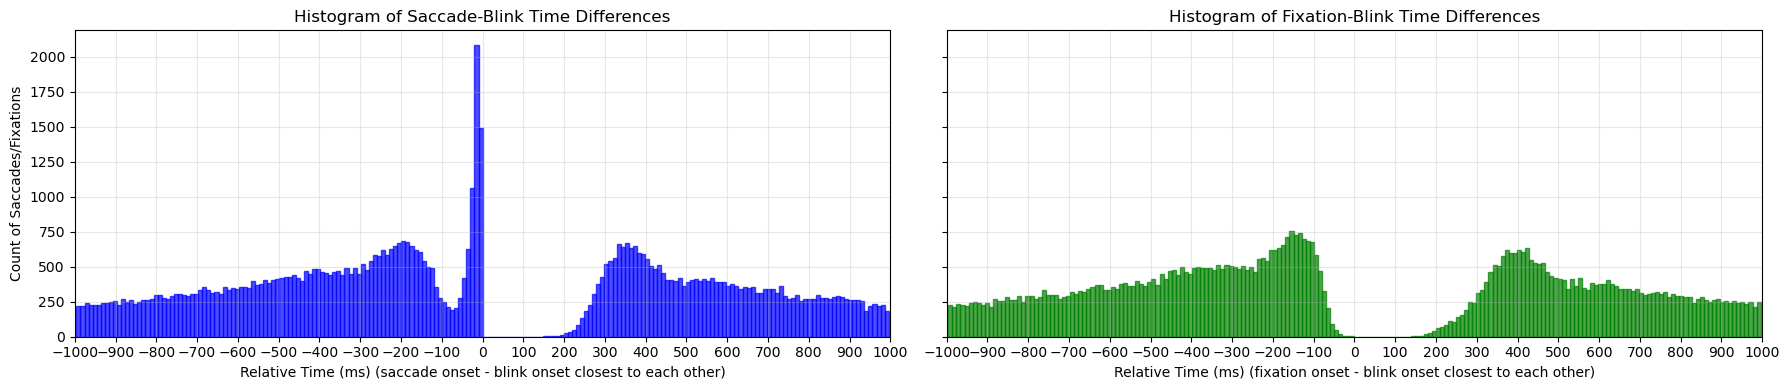

In [ ]:
## histograms (for fixations and saccades vs blinks) with relative time of blinks on the X axis and fixation or saccade count on the y axis

base_path = ""

# initiate df for all sessions combined
df_blinks_saccades_all = pd.DataFrame()
df_blinks_fixations_all = pd.DataFrame()

# loading files
for folder in os.listdir(base_path):
    participant_path = os.path.join(base_path, folder)
    if not os.path.isdir(participant_path):
        continue
    blinks_path = os.path.join(participant_path, 'blinks.csv')
    saccades_path = os.path.join(participant_path, 'saccades.csv')
    fixations_path = os.path.join(participant_path, 'fixations.csv')
  
    try:
        df_blinks = pd.read_csv(blinks_path)
        df_saccades = pd.read_csv(saccades_path)
        df_fixations = pd.read_csv(fixations_path)
    except Exception as e:
        print('Failed to read', blinks_path, e)
        print('Failed to read', saccades_path, e)
        print('Failed to read', fixations_path, e)  
        continue

    # Sort by timestamp (should be sorted already, but in case for proper merging)
    df_blinks = df_blinks.sort_values("start timestamp [ns]")
    df_saccades = df_saccades.sort_values("start timestamp [ns]")
    df_fixations = df_fixations.sort_values("start timestamp [ns]")

    # add type to the dfs, so i can merge them later and know which eye movement it is
    df_saccades['type'] = 'saccade'
    df_blinks['type'] = 'blink'
    df_fixations['type'] = 'fixation'

    ## function for filtering events within blinks (adding type valid or not valid to the events)
    def add_type(df_events, df_blinks):

        # add type column to events, default to 'valid'
        df_events['within_blinks'] = 'valid'

        # change type of events that fall within blinks to 'invalid'
        for _, blink in df_blinks.iterrows():
            start, end = blink['start timestamp [ns]'], blink['end timestamp [ns]']
            mask = (df_events['start timestamp [ns]'] >= start) & (df_events['start timestamp [ns]'] <= end)
            df_events.loc[mask, 'within_blinks'] = 'invalid'
        return df_events

    # clean df_saccades and df_fixations
    df_saccades = add_type(df_saccades, df_blinks)
    df_fixations = add_type(df_fixations, df_blinks)
    df_saccades = df_saccades[df_saccades['within_blinks'] == 'valid']
    df_fixations = df_fixations[df_fixations['within_blinks'] == 'valid']

    # keep only common columns
    df_saccades = df_saccades[['start timestamp [ns]', 'end timestamp [ns]', 'duration [ms]','type']]
    df_fixations = df_fixations[['start timestamp [ns]', 'end timestamp [ns]', 'duration [ms]','type']]
    df_blinks = df_blinks[['start timestamp [ns]', 'end timestamp [ns]', 'duration [ms]','type']]

    # merge all of them and sort by starting timestamps
    df_all = pd.concat([df_blinks, df_saccades, df_fixations]).sort_values("start timestamp [ns]")

    # Calculate time difference between saccade start and closes to it blink start
    
    # Extract saccade and blink timestamps with indices
    saccades = df_all[df_all['type'] == 'saccade'][['start timestamp [ns]']].reset_index()
    fixations = df_all[df_all['type'] == 'fixation'][['start timestamp [ns]']].reset_index()
    blinks = df_all[df_all['type'] == 'blink'][['start timestamp [ns]']].reset_index()

    def nearest_blink(sacc_fix_ts):
        if len(blinks) == 0:
            return np.nan
        diffs = np.abs(sacc_fix_ts - blinks['start timestamp [ns]'])
        #diffs = np.abs(blinks['start timestamp [ns]'] - sacc_fix_ts)
        closest_idx = diffs.idxmin()
        return sacc_fix_ts - blinks.loc[closest_idx, 'start timestamp [ns]']
        #return blinks.loc[closest_idx, 'start timestamp [ns]'] - sacc_fix_ts

    # Apply to each saccade
    saccades['saccade-blink_ns'] = saccades['start timestamp [ns]'].apply(nearest_blink)
    fixations['fixation-blink_ns'] = fixations['start timestamp [ns]'].apply(nearest_blink)
    
    # Merge back to original df_all (matching on original index)
    df_all = df_all.merge(saccades[['start timestamp [ns]', 'saccade-blink_ns']], 
                        on='start timestamp [ns]', how='left')  # NaN for non-saccades
    df_all = df_all.merge(fixations[['start timestamp [ns]', 'fixation-blink_ns']], 
                        on='start timestamp [ns]', how='left')  # NaN for non-fixations

    # leave only difference of 1 second or less to reduce plot time
    df_all = df_all[(df_all['saccade-blink_ns'].abs() <= 1e9) | (df_all['fixation-blink_ns'].abs() <= 1e9)]


    # append to all sessions df
    df_blinks_saccades_all = pd.concat([df_blinks_saccades_all, df_all[df_all['type']=='saccade']], ignore_index=True)
    df_blinks_fixations_all = pd.concat([df_blinks_fixations_all, df_all[df_all['type']=='fixation']], ignore_index=True)    

    
    ### histograms per session  
    
    """fig, axes = plt.subplots(1, 2, figsize=(18,4), sharey=True)

    # Plot histogram for saccades vs blinks
    axes[0].hist(df_all[df_all['type']=='saccade']['saccade-blink_ns'] / 1e6, bins=200, alpha=0.7, color='blue', edgecolor='blue') # 10 ms bins
    axes[0].set_title(f'{folder} Histogram of Saccade-Blink Time Differences')
    axes[0].set_xlabel('Relative Time (ms) (saccade onset - blink onset closest to each other)')
    axes[0].set_ylabel('Count of Saccades/Fixations')
    axes[0].set_xlim(-1000, 1000)
    axes[0].set_xticks(np.arange(-1000, 1001, 200))
    axes[0].grid(True, alpha=0.3)

    # Plot histogram for fixations vs blinks
    axes[1].hist(df_all[df_all['type']=='fixation']['fixation-blink_ns'] / 1e6, bins=200, alpha=0.7, color='green', edgecolor='green') # 10 ms bins
    axes[1].set_title(f'{folder} Histogram of Fixation-Blink Time Differences')
    axes[1].set_xlabel('Relative Time (ms) (fixation onset - blink onset closest to each other)')
    axes[1].set_xlim(-1000, 1000)
    axes[1].set_xticks(np.arange(-1000, 1001, 200))
    axes[1].grid(True, alpha=0.3)"""
    

# histograms for all sessions combined
fig, axes = plt.subplots(1, 2, figsize=(18,4), sharey=True)

# Plot histogram for saccades vs blinks
axes[0].hist(df_blinks_saccades_all['saccade-blink_ns'] / 1e6, bins=200, alpha=0.7, color='blue', edgecolor='blue') # 10 ms bins
axes[0].set_title('Histogram of Saccade-Blink Time Differences')
axes[0].set_xlabel('Relative Time (ms) (saccade onset - blink onset closest to each other)')
axes[0].set_ylabel('Count of Saccades/Fixations')
axes[0].set_xlim(-1000, 1000)
axes[0].set_xticks(np.arange(-1000, 1001, 100))
axes[0].grid(True, alpha=0.3)

# Plot histogram for fixations vs blinks
axes[1].hist(df_blinks_fixations_all['fixation-blink_ns'] / 1e6, bins=200, alpha=0.7, color='green', edgecolor='green') # 10 ms bins
axes[1].set_title('Histogram of Fixation-Blink Time Differences')
axes[1].set_xlabel('Relative Time (ms) (fixation onset - blink onset closest to each other)')
axes[1].set_xlim(-1000, 1000)
axes[0].set_ylabel('Count of Saccades/Fixations')
axes[1].set_xticks(np.arange(-1000, 1001, 100))
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
